## ML FX Testing - K Neighbors

In [1]:
from backtesting.test import SMA
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

data = yf.Ticker('USDEUR=X').history(period='1y', interval="1h")[['Close', 'Open', 'High','Low']]
data

/Users/edo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/Users/edo/opt/anaconda3/lib/python3.9/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/Users/edo/opt/anaconda3/lib/python3.9/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


,Close,Open,High,Low
Datetime,,,,
2023-03-27 00:00:00+01:00,0.9276,0.9276,0.9281,0.9273
2023-03-27 01:00:00+01:00,0.9289,0.9277,0.9289,0.9277
2023-03-27 02:00:00+01:00,0.9289,0.9290,0.9293,0.9285
2023-03-27 03:00:00+01:00,0.9283,0.9290,0.9290,0.9283
2023-03-27 04:00:00+01:00,0.9281,0.9280,0.9283,0.9277
...,...,...,...,...
2024-03-26 08:00:00+00:00,0.9214,0.9221,0.9223,0.9213
2024-03-26 09:00:00+00:00,0.9211,0.9215,0.9217,0.9209
2024-03-26 10:00:00+00:00,0.9209,0.9211,0.9211,0.9202


In [2]:
def BBANDS(data, n_lookback, n_std):
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [3]:
def get_X(data):
    return data.filter(like='X').values


def get_y(data):
    y = data.Close.pct_change(48).shift(-48)
    y[y.between(-.004, .004)] = 0    
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.4616656333953296


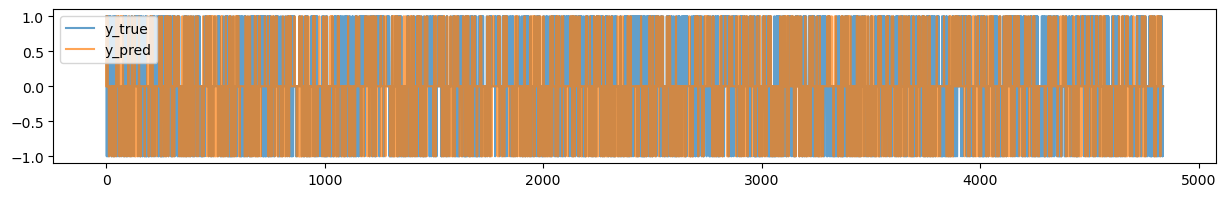

In [4]:
# Set the model

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=0)

clf = KNeighborsClassifier(7)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [5]:
from backtesting import Backtest, Strategy

end=len(data)


class MLTrainOnceStrategy(Strategy):
    price_delta = .008  #Customizable stop loss/take profit - currently 0.8%
    mysize = 0.9   #Customizable tradable size

    def init(self):        
        self.clf = KNeighborsClassifier(7)

        df = self.data.df.iloc[:end]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)
        self.I(get_y, self.data.df, name='y_true')
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]
        self.forecasts[-1] = forecast

        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=self.mysize, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=self.mysize, tp=lower, sl=upper)

        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.000, margin=1)
bt.run()

Start                     2023-03-31 03:00...
End                       2024-03-26 12:00...
Duration                    361 days 10:00:00
Exposure Time [%]                   82.513123
Equity Final [$]                  11527.73323
Equity Peak [$]                   11527.73323
Return [%]                          15.277332
Buy & Hold Return [%]                0.480089
Return (Ann.) [%]                   14.655753
Volatility (Ann.) [%]                4.174849
Sharpe Ratio                         3.510487
Sortino Ratio                        6.940612
Calmar Ratio                         7.929828
Max. Drawdown [%]                    -1.84818
Avg. Drawdown [%]                   -0.180541
Max. Drawdown Duration       44 days 15:00:00
Avg. Drawdown Duration        2 days 14:00:00
# Trades                                  394
Win Rate [%]                        60.152284
Best Trade [%]                       0.843286
Worst Trade [%]                     -0.833127
Avg. Trade [%]                    

In [6]:
bt.plot()

Row(id='1487', ...)

In [1]:
# Credit by Edoardo Alberto Donolato